# Análisis de Fourier en Acción: De las Matemáticas a las Telecomunicaciones Modernas

**Dirigido a:** Estudiantes de Ingeniería en Sistemas de Análisis Matemático III.

**Objetivo:** Este cuaderno busca desmitificar las Series de Fourier, demostrando que no son solo un concepto abstracto, sino el pilar fundamental sobre el que se construyen las tecnologías de comunicación que usamos a diario (Wi-Fi, 4G/5G, radio digital). A través de un ejemplo práctico de modulación digital, veremos cómo los ingenieros utilizan estas herramientas para convertir datos (bits) en señales que pueden viajar por el aire. Pasaremos de la teoría matemática a una simulación funcional, tocando conceptos clave de la **capa física** de los sistemas de comunicación.

## Introducción: ¿Por Qué Estudiar Series de Fourier en Ingeniería en Sistemas?

Toda señal compleja, ya sea el sonido de una guitarra, una imagen digital o una transmisión de datos por Wi-Fi, puede ser descompuesta en una suma de ondas sinusoidales simples (senos y cosenos). Esta es la idea central detrás del **Análisis de Fourier**.

Para un Ingeniero en Sistemas, esto es crucial. Si podemos entender una señal como una "receta" de componentes simples, podemos:

1.  **Transmitirla eficientemente:** Enviamos ondas sinusoidales (llamadas **portadoras**) a las que les modificamos alguna característica (amplitud, fase o frecuencia) para que "lleven" información. Esto es la **modulación**.
2.  **Filtrarla:** Eliminar ruidos o interferencias que se encuentran en frecuencias no deseadas.
3.  **Comprimirla:** Descartar componentes de frecuencia que no son importantes para reducir el tamaño de los datos (el principio detrás de MP3 o JPEG).
4.  **Analizarla:** Usar la **Transformada Rápida de Fourier (FFT)**, un algoritmo fundamental, para ver el espectro de una señal y entender cómo se distribuye su energía en frecuencia.

En este cuaderno, nos centraremos en el primer punto, la modulación, el lenguaje de las telecomunicaciones.

## Parte 1. El Concepto Fundamental: Modulación Digital QPSK

La **modulación** es el proceso de "montar" información digital (bits: 0s y 1s) sobre una onda analógica. La onda base es una simple sinusoide definida por:

$$s(t) = A \cdot \cos(2\pi f t + \phi)$$

Donde:
* $A$ es la **Amplitud** (qué tan "alta" es la onda).
* $f$ es la **Frecuencia** (qué tan "rápido" oscila).
* $\phi$ es la **Fase** (el desplazamiento inicial).

Al variar uno de estos parámetros según los bits que queremos enviar, estamos modulando la señal.

**QPSK (Quadrature Phase Shift Keying)** es una técnica muy eficiente porque codifica **2 bits** de información en cada "símbolo" o cambio de la señal. Lo hace variando la fase ($\phi$) de la portadora en cuatro valores posibles, cada uno representando un par de bits.

### 1.1. Configuración del Entorno y Parámetros

Primero, importamos las librerías y definimos los parámetros básicos de nuestra simulación.

* `fs`: **Frecuencia de muestreo**. Según el **Teorema de Nyquist**, debe ser al menos el doble de la frecuencia máxima de la señal para poder reconstruirla sin pérdidas. Usaremos un valor alto para una buena resolución.
* `f`: **Frecuencia de la onda portadora**.
* `t_simbolo`: **Duración** de cada símbolo (cada par de bits).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy.fft import fft, fftfreq

# --- Parámetros Básicos de la Simulación ---
fs = 1000  # Frecuencia de muestreo (Hz)
f = 5      # Frecuencia de la portadora (Hz)
t_simbolo = 1.0  # Duración de cada símbolo (s)
n_muestras_por_simbolo = int(t_simbolo * fs)

### 1.2. La "Traducción": Tabla de Símbolos QPSK

Creamos un "diccionario" que traduce cada posible par de bits a un cambio de fase específico. Las fases están separadas por 90° ($\pi/2$ radianes) para maximizar la diferencia entre ellas y facilitar su posterior detección.

In [ ]:
# --- Tabla de Símbolos QPSK (2 bits por símbolo) ---
# Mapeo: "Bits" -> Fase en radianes (y grados para claridad)
tabla_simbolos = {
    "00": 0,                # 0°
    "01": np.pi / 2,        # 90°
    "11": np.pi,            # 180°
    "10": 3 * np.pi / 2     # 270°
}

### 1.3. Generación de la Señal Modulada

Ahora, tomamos un mensaje binario y lo convertimos en una señal analógica. Para cada par de bits del mensaje, generamos una onda coseno con la fase correspondiente y las concatenamos para formar la señal final.

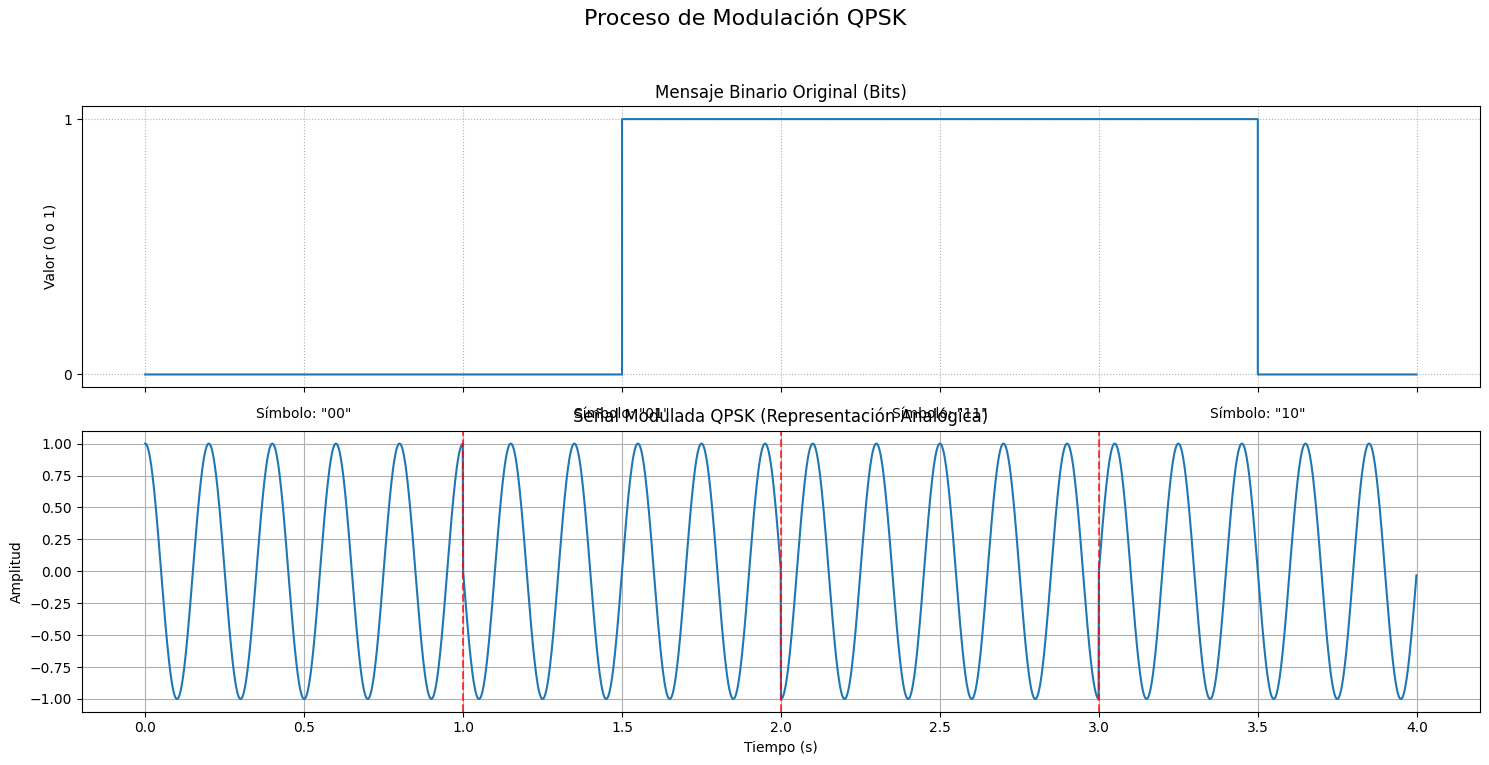

In [ ]:
# --- Mensaje y Simbolización ---
mensaje_binario = "00011110"
# Agrupamos el mensaje en símbolos de 2 bits
simbolos = [mensaje_binario[i:i+2] for i in range(0, len(mensaje_binario), 2)]

# --- Generación de la Señal ---
t_total = np.linspace(0, len(simbolos) * t_simbolo, len(simbolos) * n_muestras_por_simbolo, endpoint=False)
senal_modulada = np.zeros_like(t_total)

for i, bits in enumerate(simbolos):
    fase = tabla_simbolos[bits]
    t_local = np.linspace(0, t_simbolo, n_muestras_por_simbolo, endpoint=False)
    # Creamos la onda para el símbolo actual
    onda = np.cos(2 * np.pi * f * t_local + fase)
    # La añadimos a la señal completa
    senal_modulada[i * n_muestras_por_simbolo:(i + 1) * n_muestras_por_simbolo] = onda

# --- Visualización Mejorada ---
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle('Proceso de Modulación QPSK', fontsize=16)

# 1. Gráfico de la señal digital (mensaje)
ax = axs[0]
bits_plot = np.array([int(b) for b in mensaje_binario for _ in range(int(fs * t_simbolo / 2))])
t_bits = np.linspace(0, len(simbolos) * t_simbolo, len(bits_plot), endpoint=False)
ax.plot(t_bits, bits_plot, drawstyle='steps-post')
ax.set_title("Mensaje Binario Original (Bits)")
ax.set_ylabel("Valor (0 o 1)")
ax.set_yticks([0, 1])
ax.grid(True, which='both', linestyle=':')

# 2. Gráfico de la señal modulada
ax = axs[1]
ax.plot(t_total, senal_modulada)
ax.set_title("Señal Modulada QPSK (Representación Analógica)")
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud")
ax.grid(True)

# Añadir líneas verticales para mostrar dónde cambia el símbolo
for i in range(1, len(simbolos)):
    ax.axvline(x=i * t_simbolo, color='r', linestyle='--', alpha=0.7)
    # Anotar qué símbolo se está transmitiendo
    ax.text(i * t_simbolo - t_simbolo/2, 1.2, f'Símbolo: "{simbolos[i-1]}"', ha='center', backgroundcolor='white')
ax.text(len(simbolos) * t_simbolo - t_simbolo/2, 1.2, f'Símbolo: "{simbolos[-1]}"', ha='center', backgroundcolor='white')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Análisis del Gráfico:** Observa cómo la onda sinusoidal cambia su fase (su punto de inicio) cada segundo, justo donde las líneas rojas marcan el cambio de símbolo. Por ejemplo, en $t=1$s, la fase cambia de 0° (para el símbolo "00") a 90° (para el símbolo "01"), lo que se manifiesta como un "salto" evidente en la forma de la onda.

## Parte 2. La Magia de Fourier: El Espectro de Frecuencia 🕵️‍♂️

Nuestra señal modulada parece compleja, pero el Teorema de Fourier nos dice que es solo una combinación de senos y cosenos. La **Transformada Rápida de Fourier (FFT)** es el algoritmo que nos permite ver exactamente qué "ingredientes" (frecuencias) componen nuestra señal.

Este es el puente directo entre la matemática de la materia y el problema de ingeniería.

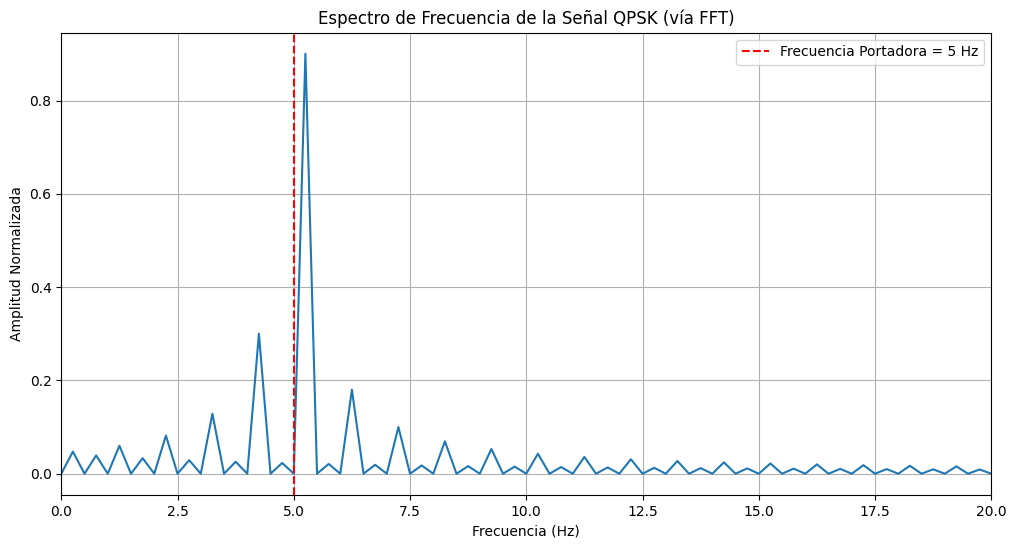

In [ ]:
# Calculamos la FFT de nuestra señal modulada
N = len(senal_modulada)
yf = fft(senal_modulada)
xf = fftfreq(N, 1/fs)[:N//2] # Tomamos las frecuencias positivas

# Graficamos el espectro de frecuencia
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title("Espectro de Frecuencia de la Señal QPSK (vía FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud Normalizada")
plt.grid(True)
plt.axvline(x=f, color='r', linestyle='--', label=f'Frecuencia Portadora = {f} Hz')
plt.legend()
plt.xlim(0, 20)
plt.show()

**Análisis del Espectro:** ¡Aquí está la conexión! El pico principal aparece exactamente en **5 Hz**, que es la frecuencia de nuestra onda portadora ($f$). Las pequeñas "jorobas" a su alrededor (llamadas lóbulos laterales) son introducidas por los cambios bruscos de fase; en esencia, **son la información** que hemos codificado en la señal.

En sistemas reales como OFDM (usado en 4G/5G y Wi-Fi), se usan miles de portadoras a la vez. La FFT es la herramienta que permite al receptor separarlas y leer la información de cada una.

## Parte 3. El Mundo Real: Ruido y Demodulación

En la vida real, las señales se corrompen con **ruido** (interferencias, otros dispositivos, etc.). Simularemos esto añadiendo ruido gaussiano a nuestra señal.

El reto del receptor (**demodulador**) es adivinar cuál era el mensaje original a partir de esta señal ruidosa.

### 3.1. Simulación del Canal con Ruido

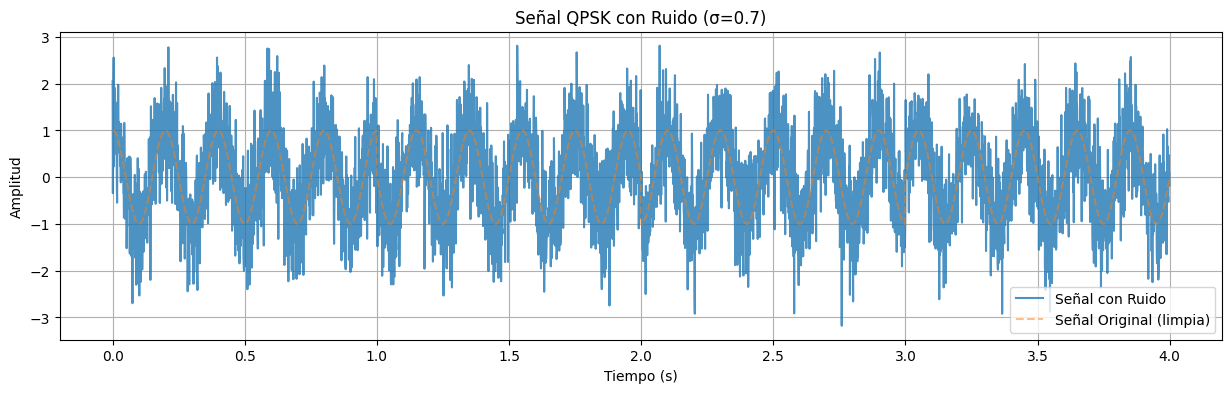

In [ ]:
# --- Añadir Ruido Gaussiano ---
sigma = 0.7  # Desviación estándar del ruido (controla la intensidad)
ruido = np.random.normal(0, sigma, len(senal_modulada))
senal_con_ruido = senal_modulada + ruido

# --- Gráfico de la señal ruidosa ---
plt.figure(figsize=(15, 4))
plt.plot(t_total, senal_con_ruido, label='Señal con Ruido', alpha=0.8)
plt.plot(t_total, senal_modulada, label='Señal Original (limpia)', linestyle='--', alpha=0.5)
plt.title(f"Señal QPSK con Ruido (σ={sigma})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()

### 3.2. Demodulación por Correlación: La Proyección de Fourier

¿Cómo recuperamos los bits? Usamos una técnica llamada **correlación**. Es como "comparar" cada trozo de la señal ruidosa con las 4 ondas "perfectas" (plantillas) que representan a "00", "01", "11" y "10". La plantilla que más se parezca es la que probablemente se envió.

Matemáticamente, esta "comparación" se hace con el **producto punto (dot product)**. Este proceso es, en esencia, calcular los coeficientes de Fourier: estamos **proyectando** nuestra señal recibida sobre las ondas base (nuestras plantillas) para ver cuál tiene la mayor contribución.

In [ ]:
# --- Proceso de Demodulación ---
bits_recuperados = ""
puntos_recibidos_I = [] # Para el diagrama de constelación (componente En-Fase)
puntos_recibidos_Q = [] # Para el diagrama de constelación (componente en Cuadratura)

# 1. Generamos las plantillas de referencia
plantillas = {}
t_local_demod = np.linspace(0, t_simbolo, n_muestras_por_simbolo, endpoint=False)
for bits, fase in tabla_simbolos.items():
    plantilla = np.cos(2 * np.pi * f * t_local_demod + fase)
    plantillas[bits] = plantilla

# 2. Segmentamos la señal y correlacionamos
for i in range(len(simbolos)):
    segmento = senal_con_ruido[i * n_muestras_por_simbolo:(i + 1) * n_muestras_por_simbolo]

    correlaciones = {bits: np.dot(segmento, p) for bits, p in plantillas.items()}

    # Proyectamos la señal en las bases I (cos) y Q (-sin) sin fase para la constelación
    base_I = np.cos(2 * np.pi * f * t_local_demod)
    base_Q = -np.sin(2 * np.pi * f * t_local_demod)
    puntos_recibidos_I.append(np.dot(segmento, base_I))
    puntos_recibidos_Q.append(np.dot(segmento, base_Q))

    # 3. El símbolo con la correlación más alta es nuestra decisión
    mejor_ajuste = max(correlaciones, key=correlaciones.get)
    bits_recuperados += mejor_ajuste

# --- Resultados ---
errores = sum(1 for a, b in zip(mensaje_binario, bits_recuperados) if a != b)
ber = errores / len(mensaje_binario)

print("--- RESULTADOS DE LA DEMODULACIÓN ---")
print(f"Mensaje original   : {mensaje_binario}")
print(f"Bits recuperados   : {bits_recuperados}")
print(f"Coinciden          : {mensaje_binario == bits_recuperados}")
print(f"Errores de bits    : {errores} de {len(mensaje_binario)}")
print(f"Tasa de error (BER): {ber:.3f}")

--- RESULTADOS DE LA DEMODULACIÓN ---
Mensaje original   : 00011110
Bits recuperados   : 00011110
Coinciden          : True
Errores de bits    : 0 de 8
Tasa de error (BER): 0.000


## Parte 4. Visualización Avanzada: El Diagrama de Constelación 🌌

Esta es una de las herramientas visuales más importantes en telecomunicaciones. Muestra en un plano 2D los "puntos" ideales de cada símbolo y dónde aterrizaron los puntos recibidos después de ser afectados por el ruido. Cuanto más se dispersen los puntos recibidos, mayor es el ruido y la probabilidad de error.

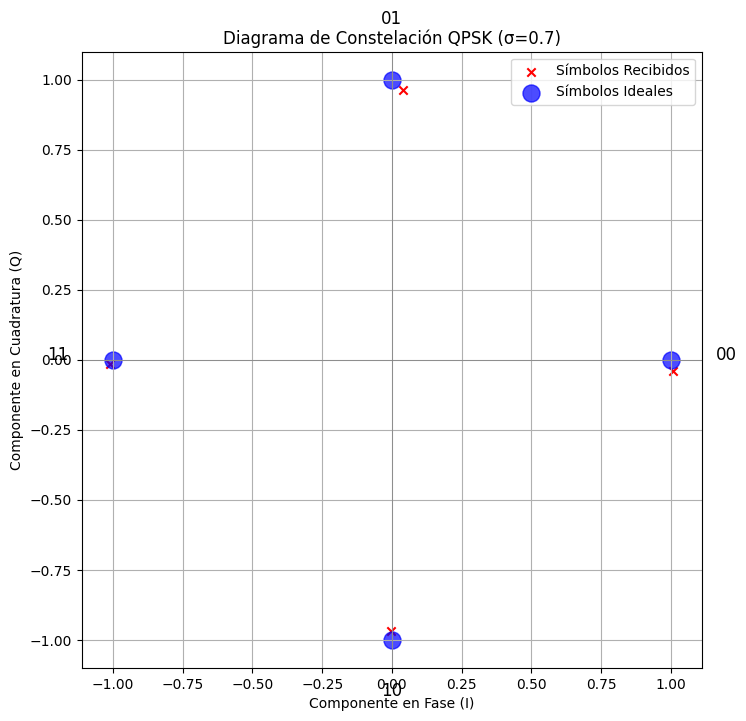

In [ ]:
# --- Puntos Ideales de la Constelación ---
# Normalizamos por la energía del símbolo
energia_simbolo = np.sum(np.cos(2*np.pi*f*t_local_demod)**2)
puntos_ideales_x = [np.cos(fase) for fase in tabla_simbolos.values()]
puntos_ideales_y = [np.sin(fase) for fase in tabla_simbolos.values()]


# --- Gráfico de la Constelación ---
plt.figure(figsize=(8, 8))
# Graficar puntos recibidos (normalizados)
rec_x = np.array(puntos_recibidos_I) / energia_simbolo
rec_y = -np.array(puntos_recibidos_Q) / energia_simbolo # el signo negativo es por la base -sin(wt)
plt.scatter(rec_x, rec_y, c='red', label='Símbolos Recibidos', marker='x')

# Graficar puntos ideales
plt.scatter(puntos_ideales_x, puntos_ideales_y, s=150, c='blue', label='Símbolos Ideales', marker='o', alpha=0.7)

# Etiquetas y estilo
for bits, pos in zip(tabla_simbolos.keys(), zip(puntos_ideales_x, puntos_ideales_y)):
    plt.text(pos[0] * 1.2, pos[1] * 1.2, bits, fontsize=12, ha='center')

plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.title(f"Diagrama de Constelación QPSK (σ={sigma})")
plt.xlabel("Componente en Fase (I)")
plt.ylabel("Componente en Cuadratura (Q)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

**Análisis de la Constelación:** Los puntos azules son las "metas" perfectas para cada símbolo. Los puntos rojos son los que recibimos, desplazados por el ruido. Mientras los puntos rojos estén más cerca de su "meta" azul que de cualquier otra, el demodulador tomará la decisión correcta. Si el ruido es tan fuerte que un punto rojo cruza la frontera hacia otra zona, ocurrirá un error de bit.

## Parte 5. TODO EN UNO!
Vamos empaquetando todo el proceso en una función interactiva. Usa los deslizadores para cambiar la **frecuencia de la portadora** y el **nivel de ruido** y observa en tiempo real cómo afectan a la señal, su espectro, la constelación y la tasa de error (BER).

In [ ]:
def simulacion_qpsk_interactiva(f_portadora, sigma_ruido):
    # Parámetros
    fs = 1000
    t_simbolo = 1.0
    n_muestras_por_simbolo = int(t_simbolo * fs)

    # Tabla de símbolos
    tabla_simbolos = { "00": 0, "01": np.pi/2, "11": np.pi, "10": 3*np.pi/2 }

    # Mensaje
    mensaje_binario = "0001111000111001"
    simbolos = [mensaje_binario[i:i+2] for i in range(0, len(mensaje_binario), 2)]

    # Modulación
    t_total = np.linspace(0, len(simbolos) * t_simbolo, len(simbolos) * n_muestras_por_simbolo, endpoint=False)
    senal_modulada = np.zeros_like(t_total)
    for i, bits in enumerate(simbolos):
        onda = np.cos(2 * np.pi * f_portadora * np.linspace(0, t_simbolo, n_muestras_por_simbolo, endpoint=False) + tabla_simbolos[bits])
        senal_modulada[i*n_muestras_por_simbolo:(i+1)*n_muestras_por_simbolo] = onda

    # Canal con ruido
    ruido = np.random.normal(0, sigma_ruido, len(senal_modulada))
    senal_con_ruido = senal_modulada + ruido

    # Demodulación
    bits_recuperados = ""
    puntos_recibidos_I, puntos_recibidos_Q = [], []
    t_local_demod = np.linspace(0, t_simbolo, n_muestras_por_simbolo, endpoint=False)
    plantillas = {bits: np.cos(2 * np.pi * f_portadora * t_local_demod + fase) for bits, fase in tabla_simbolos.items()}

    base_I = np.cos(2 * np.pi * f_portadora * t_local_demod)
    base_Q = -np.sin(2 * np.pi * f_portadora * t_local_demod)

    for i in range(len(simbolos)):
        segmento = senal_con_ruido[i*n_muestras_por_simbolo:(i+1)*n_muestras_por_simbolo]
        correlaciones = {bits: np.dot(segmento, p) for bits, p in plantillas.items()}
        puntos_recibidos_I.append(np.dot(segmento, base_I))
        puntos_recibidos_Q.append(np.dot(segmento, base_Q))
        bits_recuperados += max(correlaciones, key=correlaciones.get)

    errores = sum(1 for a, b in zip(mensaje_binario, bits_recuperados) if a != b)
    ber = errores / len(mensaje_binario)

    # --- Visualización ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'f_portadora = {f_portadora} Hz, Ruido σ = {sigma_ruido:.2f}, BER = {ber:.3f}', fontsize=16)

    # Señal con Ruido
    axs[0, 0].plot(t_total, senal_con_ruido, alpha=0.8)
    axs[0, 0].set_title("Señal con Ruido")
    axs[0, 0].set_xlabel("Tiempo (s)")
    axs[0, 0].set_ylabel("Amplitud")
    axs[0, 0].grid(True)
    axs[0, 0].set_xlim(0, 4)

    # Espectro de Frecuencia
    N = len(senal_con_ruido)
    yf = fft(senal_con_ruido)
    xf = fftfreq(N, 1/fs)[:N//2]
    axs[0, 1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    axs[0, 1].axvline(x=f_portadora, color='r', linestyle='--', label=f'Portadora')
    axs[0, 1].set_title("Espectro de Frecuencia (FFT)")
    axs[0, 1].set_xlabel("Frecuencia (Hz)")
    axs[0, 1].grid(True)
    axs[0, 1].set_xlim(0, f_portadora * 4)
    axs[0, 1].legend()

    # Diagrama de Constelación
    energia_simbolo = np.sum(base_I**2)
    rec_x = np.array(puntos_recibidos_I) / energia_simbolo
    rec_y = np.array(puntos_recibidos_Q) / energia_simbolo
    axs[1, 0].scatter(rec_x, rec_y, c='red', marker='x', label='Recibidos')

    p_ideales_x = [np.cos(f) for f in tabla_simbolos.values()]
    p_ideales_y = [np.sin(f) for f in tabla_simbolos.values()]
    axs[1, 0].scatter(p_ideales_x, p_ideales_y, s=150, c='blue', marker='o', alpha=0.7, label='Ideales')

    axs[1, 0].set_title("Diagrama de Constelación")
    axs[1, 0].set_xlabel("Componente I")
    axs[1, 0].set_ylabel("Componente Q")
    axs[1, 0].grid(True)
    axs[1, 0].axis('equal')
    axs[1, 0].legend()

    # Texto de Resultados
    axs[1, 1].axis('off')
    info_text = (f"Mensaje Original:   {mensaje_binario}\n"
                 f"Bits Recuperados:   {bits_recuperados}\n"
                 f"Coinciden:          {mensaje_binario == bits_recuperados}\n\n"
                 f"Errores de Bits:    {errores} de {len(mensaje_binario)}\n"
                 f"BER:                {ber:.3f}")
    axs[1, 1].text(0.05, 0.5, info_text, va='center', fontsize=12, fontfamily='monospace')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Crear y mostrar los widgets ---
style = {'description_width': 'initial'}
f_slider = widgets.FloatSlider(value=10, min=2, max=50, step=1, description='Frecuencia Portadora (Hz):', style=style)
sigma_slider = widgets.FloatSlider(value=0.5, min=0, max=2.0, step=0.05, description='Nivel de Ruido (σ):', style=style)

widgets.interactive(simulacion_qpsk_interactiva, f_portadora=f_slider, sigma_ruido=sigma_slider)

interactive(children=(FloatSlider(value=10.0, description='Frecuencia Portadora (Hz):', max=50.0, min=2.0, ste…

## Conclusiones

Hoy hemos viajado desde la abstracta fórmula de una onda sinusoidal hasta la simulación de un sistema de comunicación digital. Hemos visto que:

1.  **Las Series de Fourier no son solo teoría:** Las ondas seno y coseno son los "ladrillos" con los que construimos señales complejas para transmitir datos. La modulación es la aplicación directa de esta idea.
2.  **La FFT es una herramienta de ingeniería esencial:** Nos permitió "ver" el contenido de nuestra señal en el dominio de la frecuencia, identificando la portadora y la información. Es una herramienta de diagnóstico y diseño fundamental.
3.  **La demodulación es una "proyección de Fourier":** Al correlacionar la señal recibida con nuestras plantillas, estábamos, en efecto, calculando los coeficientes de Fourier para determinar qué "componente base" era el más probable.

Este cuaderno es solo el comienzo. A partir de aquí, se pueden explorar modulaciones más complejas como QAM (variando también la amplitud), el efecto de errores de sincronización, o el diseño de sistemas multiportadora como OFDM, donde la FFT no es solo una herramienta de análisis, sino el motor principal del sistema.

Esperamos que esta demostración práctica haya servido para motivar y clarificar la importancia del Análisis Matemático en el mundo real de la Ingeniería en Sistemas.